In [1]:
import nptsne
from nptsne import hsne_analysis
from pathlib import Path
import numpy as np
import community as community_louvain
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from tqdm import tqdm
from sklearn.utils import check_random_state, check_array
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.decomposition import PCA
import scprep
import os
import time


fashionTrain = pd.read_csv('data/fashion-train.csv')

fashionX = fashionTrain.values[:,2:]
fashionY = fashionTrain.values[:, 1].astype(int)

print(fashionX.shape, fashionY.shape)

X = fashionX
X = normalize(X)
lab = fashionY.astype(int)




# X = np.load('./data/MNIST_70000.npy')
# lab = np.load('./data/MNIST_70000_label.npy').astype(int)
# X = normalize(X)


# data = pd.read_csv('data/mnist_max_pooling2d_dense.data', header=None)
# data = data.drop(columns=[0])
# X = data.values[:, :-1]
# lab = data.values[:, -1]


# X = np.loadtxt("data/news_X.txt")
# lab = np.loadtxt("data/news_labels.txt")



# data = pd.read_csv('data/gene_expression.csv')
# X = data.values[:, :-1]
# lab = data.values[:, -1]
# X = np.log(X+1)
# # X = normalize(X)
# X = PCA(n_components=100).fit_transform(X)

def load_scRNAseq():
    download_path = os.path.expanduser("~/Documentos/HierarchicalUMAP/umap-cpp/umap/cpp/data")
    sparse=True
    T1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
    T2 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
    T3 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
    T4 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
    T5 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
    print("done 1")
    filtered_batches = []
    for batch in [T1, T2, T3, T4, T5]:
        batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
        batch = scprep.filter.filter_library_size(batch, percentile=75, keep_cells='below')
        filtered_batches.append(batch)
    del T1, T2, T3, T4, T5
    print("done 2")
    EBT_counts, sample_labels = scprep.utils.combine_batches(
        filtered_batches, 
        ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"],
        append_to_cell_names=True
    )
    del filtered_batches # removes objects from memory
    print("done 3")
    EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)
    EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)
    mito_genes = scprep.select.get_gene_set(EBT_counts, starts_with="MT-") # Get all mitochondrial genes. There are 14, FYI.
    EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, keep_cells='below')
    print("done 4")
    EBT_counts = scprep.transform.sqrt(EBT_counts)
    
    le = LabelEncoder()
    le.fit(sample_labels)
    labels = le.transform(sample_labels)
    print("done 5")
    X = PCA(n_components=20).fit_transform(EBT_counts.values)
    return X, labels

    
# X, y = load_scRNAseq()


def get_cifar10():
    data = np.load('data/features/CIFAR10_vgg19-keras_features.npz')
    
    X_training = data['features_training']
    y_training = data['labels_training']
        
    X_testing = data['features_testing']
    y_testing = data['labels_testing']
    
    X = np.concatenate((X_training, X_testing))
    y = np.concatenate((y_training, y_testing))
        
    return X_training, y_training
    
# X, y = get_cifar10()    

# X = np.loadtxt("data/mammals-20000_features.txt")
# lab = np.loadtxt("data/mammals-20000_classes.txt")
# X = normalize(X)

def load_sun():
        
    X = np.load('./data/small_sun.npy')
    y = np.zeros(X.shape[0]).astype(int)
    return X, y

# X, lab = load_sun()


X = check_array(X, dtype=np.float32, accept_sparse="csr", order="C")

# X_noised = X + np.random.normal(loc=0, scale=1, size=X.shape)*0.04


dataset = 'fashion'
print('Size data:', X.shape)

(60000, 784) (60000,)
Size data: (60000, 784)


In [2]:
tic = time.time()
hsne = nptsne.HSne(True)
# Create a 3 scale HSNE analysis from the MNIST data
hsne.create_hsne(X, 3)
toc = time.time()
# print(hsne.get_scale(0).num_points, hsne.get_scale(1).num_points)
# print(hsne.get_scale(0).num_points, hsne.get_scale(1).num_points, hsne.get_scale(2).num_points)
# print(hsne.get_scale(0).num_points, hsne.get_scale(1).num_points, hsne.get_scale(2).num_points, hsne.get_scale(3).num_points)
print("%.4f seconds" % (toc - tic))


6.5094 seconds


In [11]:
container = hsne_analysis.AnalysisModel(hsne, hsne_analysis.EmbedderType.GPU)

In [12]:
analysis_level3 = container.top_analysis
len(analysis_level3.landmark_orig_indexes)

8594

In [13]:
for i in tqdm(range(500)):
    analysis_level3.do_iteration()

100%|██████████| 500/500 [00:00<00:00, 584.18it/s]


In [14]:
y_analysis_level3 = lab[analysis_level3.landmark_orig_indexes]

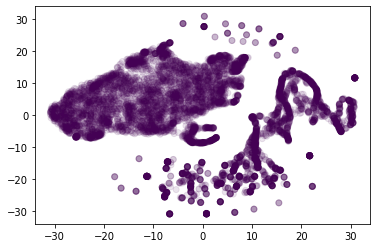

In [16]:
plt.scatter(analysis_level3.embedding[:, 0], analysis_level3.embedding[:, 1], 
            c = y_analysis_level3, alpha = 0.1)
plt.savefig('figs/'+dataset+'-hsne-level3.png')

In [8]:
analysis_level2 = container.add_new_analysis(analysis_level3, np.arange(len(y_analysis_level3)))
len(analysis_level2.landmark_orig_indexes)

11067

In [9]:
for i in tqdm(range(500)):
    analysis_level2.do_iteration()

100%|██████████| 500/500 [00:01<00:00, 396.66it/s]


In [10]:
y_analysis_level2 = lab[analysis_level2.landmark_orig_indexes]
len(y_analysis_level2)

11067

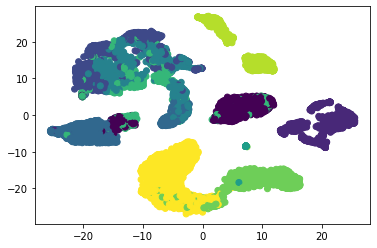

In [11]:
plt.scatter(analysis_level2.embedding[:, 0], analysis_level2.embedding[:, 1], 
            c = y_analysis_level2)
plt.savefig('figs/'+dataset+'-hsne-level2.png')
# inds = y_analysis_level2 == 2
# plt.scatter(analysis_level2.embedding[inds, 0], analysis_level2.embedding[inds, 1], 
#             c = 'black', s=10)
# plt.savefig("hsne_level2.svg")
# plt.show()

In [12]:
analysis_level1 = container.add_new_analysis(analysis_level2, np.arange(len(y_analysis_level2)))
len(analysis_level1.landmark_orig_indexes)

60000

In [13]:
for i in tqdm(range(500)):
    analysis_level1.do_iteration()

100%|██████████| 500/500 [00:03<00:00, 163.79it/s]


In [14]:
y_analysis_level1 = lab[analysis_level1.landmark_orig_indexes]
len(y_analysis_level1)

60000

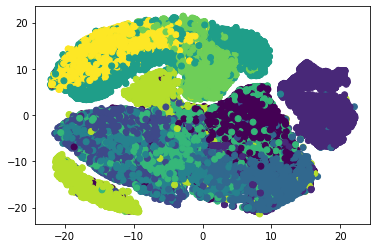

In [15]:
plt.scatter(analysis_level1.embedding[:, 0], analysis_level1.embedding[:, 1], 
            c = y_analysis_level1)
plt.savefig("figs/"+dataset+"-hsne-level1.png")

In [16]:
analysis_level0 = container.add_new_analysis(analysis_level1, np.arange(len(y_analysis_level1)))
len(analysis_level0.landmark_orig_indexes)

0

In [17]:
for i in tqdm(range(500)):
    analysis_level0.do_iteration()

100%|██████████| 500/500 [00:00<00:00, 2491.35it/s]


In [18]:
y_analysis_level0 = lab[analysis_level0.landmark_orig_indexes]
y_analysis_level0

array([], dtype=int64)

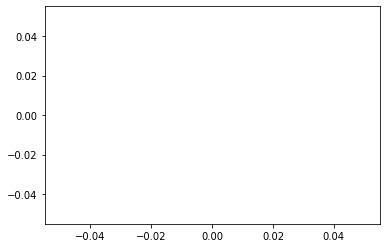

In [19]:
plt.scatter(analysis_level0.embedding[:, 0], analysis_level0.embedding[:, 1], c = y_analysis_level0, 
            cmap='Spectral')
plt.savefig("figs/"+dataset+"-hsne-level0.png")
# plt.savefig("hsne_level0.svg")
# plt.show()

In [16]:
indices = []
for i in range(len(y_analysis_level3)):
    if y_analysis_level3[i] in [0,2,3,4,6,8]:
        indices.append(i)


analysis_cluster1 = container.add_new_analysis(analysis_level3, np.array(indices))
# len(analysis_cluster.landmark_orig_indexes), analysis_cluster.landmark_orig_indexes

In [17]:
for i in tqdm(range(500)):
    analysis_cluster1.do_iteration()

100%|██████████| 500/500 [00:00<00:00, 578.86it/s]


In [18]:
y_analysis_cluster1 = lab[analysis_cluster1.landmark_orig_indexes]
len(y_analysis_cluster1)

6579

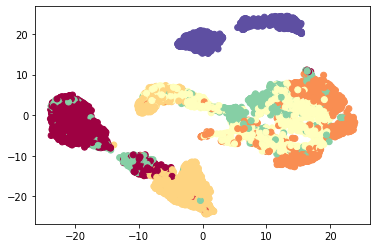

In [19]:
plt.scatter(analysis_cluster1.embedding[:, 0], analysis_cluster1.embedding[:, 1],
            c = y_analysis_cluster1, cmap='Spectral')
plt.savefig("figs/"+dataset+"-hsne-expand1.png")

In [20]:
# indices = []
# for i in range(len(y_analysis_level2)):
#     if y_analysis_level2[i] in [5,7,9]:
#         indices.append(i)


analysis_cluster = container.add_new_analysis(analysis_cluster1, np.arange(len(y_analysis_cluster1)))
# len(analysis_cluster.landmark_orig_indexes), analysis_cluster.landmark_orig_indexes

In [21]:
for i in tqdm(range(500)):
    analysis_cluster.do_iteration()

100%|██████████| 500/500 [00:01<00:00, 255.87it/s]


In [22]:
y_analysis_cluster = lab[analysis_cluster.landmark_orig_indexes]
len(y_analysis_cluster)

36387

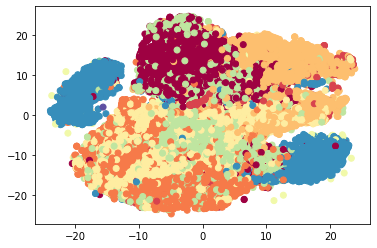

In [23]:
plt.scatter(analysis_cluster.embedding[:, 0], analysis_cluster.embedding[:, 1],
            c = y_analysis_cluster, cmap='Spectral')
plt.savefig("figs/"+dataset+"-hsne-expand2.png")

In [41]:
# indices = []
# for i in range(len(y_analysis_level1)):
#     if y_analysis_level1[i] in [5,7,9]:
#         indices.append(i)


analysis_cluster0 = container.add_new_analysis(analysis_cluster, np.arange(len(y_analysis_cluster)))#np.array(indices))


In [42]:
for i in tqdm(range(500)):
    analysis_cluster0.do_iteration()

100%|██████████| 500/500 [00:00<00:00, 2029.09it/s]


In [43]:
y_analysis_cluster0 = lab[analysis_cluster0.landmark_orig_indexes]

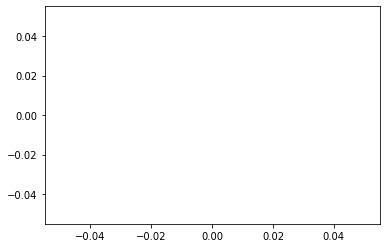

In [44]:
plt.scatter(analysis_cluster0.embedding[:, 0], analysis_cluster0.embedding[:, 1], 
            c = y_analysis_cluster0, cmap='Spectral')
plt.savefig("figs/"+dataset+"-hsne-expand3.png")

In [25]:
import demap
import random
import math
from sklearn.metrics import euclidean_distances

from sklearn.neighbors import NearestNeighbors

from scipy.stats import pearsonr

def correlation(X, X_emb):
    
    high = []
    emb = []
    
    for i in range(X.shape[0]):
        for j in range(i+1, X.shape[0]):
            high.append(np.linalg.norm(X[i]-X[j]))
            emb.append(np.linalg.norm(X_emb[i]-X_emb[j]))
    
    high = np.array(high)
    emb = np.array(emb)
    
    return pearsonr(high, emb)[0]

def stress(X, X_emb):
    
#     num = 0.0
#     den = 0.0
    
#     for i in range(X.shape[0]):
#         for j in range(X.shape[0]):
#             num += (np.linalg.norm(X[i]-X[j]) - np.linalg.norm(X_emb[i]-X_emb[j]))**2
            
#             den += np.linalg.norm(X_emb[i]-X_emb[j])**2
            
#     return math.sqrt(num/den)
    
    
    
    DE = euclidean_distances(X_emb)
    DE = DE/np.max(DE)
    DH = euclidean_distances(X)
    DH = DH/np.max(DH)
    stress = 0.5 * np.sum((DE - DH)**2)
    
    return np.sqrt(stress/(0.5*np.sum(DH**2)))
    

    

def NNP(X, X_emb, Khigh=30):
    neigh_high = NearestNeighbors(n_neighbors=Khigh, n_jobs=-1)
    neigh_high.fit(X)
    high_dists, high_indices = neigh_high.kneighbors(X)


    neigh_emb = NearestNeighbors(n_neighbors=Khigh, n_jobs=-1)
    neigh_emb.fit(X_emb)
    emb_dists, emb_indices = neigh_emb.kneighbors(X_emb)

    m_precision = np.zeros(Khigh)
    m_recall = np.zeros(Khigh)
    
    for i in tqdm(range(X.shape[0])):
        high_current = high_indices[i][1:]
        for k in range(1, Khigh+1):
            emb_current = emb_indices[i][1:k+1]            
            
            tp = len(np.intersect1d(high_current, emb_current))
            
            precision_val = float(tp)/k
            recall_val = float(tp)/Khigh
            
            m_precision[k-1] += precision_val
            m_recall[k-1] += recall_val
    
    m_precision = m_precision/float(X.shape[0])
    m_recall = m_recall/float(X.shape[0])
    
            
    return m_precision, m_recall


def neighborhood_preservation(X, X_emb, Khigh=30):
    
    neigh_high = NearestNeighbors(n_neighbors=Khigh+1, n_jobs=-1)
    neigh_high.fit(X)
    high_dists, high_indices = neigh_high.kneighbors(X)


    neigh_emb = NearestNeighbors(n_neighbors=Khigh+1, n_jobs=-1)
    neigh_emb.fit(X_emb)
    emb_dists, emb_indices = neigh_emb.kneighbors(X_emb)

    npres = np.zeros(Khigh)
    
    for k in range(1, Khigh+1):
        for i in range(X.shape[0]):
            high_current = high_indices[i][1:k+1]
            emb_current = emb_indices[i][1:k+1]
            
            tp = len(np.intersect1d(high_current, emb_current))
            
            npres[k-1] += (tp/k)
        
        
    npres /= float(X.shape[0])
    
    return npres
    
    


stress:  0.3690893297763699


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (2024, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap:  0.5497411520392086
pearsonr:  0.6375403855857248
[0.12252964 0.18132411 0.23418972 0.27865613 0.30988142 0.33613307
 0.36363636 0.38704298 0.40881643 0.42890316 0.44704456 0.46327404
 0.47932502 0.49258893 0.50546772 0.51676754 0.52833643 0.53947079
 0.54943312 0.55805336 0.56629964 0.57406576 0.58287506 0.59025033
 0.59721344 0.6055412  0.61284951 0.62078275 0.62758961 0.63389328]


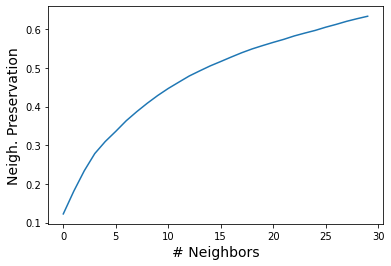

In [26]:
fourth_level = X[analysis_level3.landmark_orig_indexes,:]
fourth_embedding = analysis_level3.embedding

indices_4 = random.sample(range(0, len(fourth_embedding)), min(3000, len(fourth_embedding)))

fourth_embedding = fourth_embedding[indices_4]
fourth_level = fourth_level[indices_4]



noise = np.random.normal(0, .1, fourth_level.shape)
print("stress: ", stress(fourth_level, fourth_embedding))
print("demap: ", demap.DEMaP(fourth_level, fourth_embedding))
print("pearsonr: ", correlation(fourth_level, fourth_embedding))


ks = 30

npres = neighborhood_preservation(fourth_level, fourth_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-level3-np.png")
plt.show()

stress:  0.4567692314436194


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (3000, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap:  0.4060384585025921
pearsonr:  0.4666896537068179
[0.15366667 0.21816667 0.26533333 0.30025    0.3288     0.35277778
 0.37314286 0.39116667 0.40848148 0.42376667 0.437      0.44944444
 0.46110256 0.47161905 0.48093333 0.48991667 0.49743137 0.50496296
 0.51268421 0.52033333 0.52828571 0.53583333 0.54305797 0.549125
 0.55470667 0.56028205 0.56534568 0.57072619 0.57552874 0.58004444]


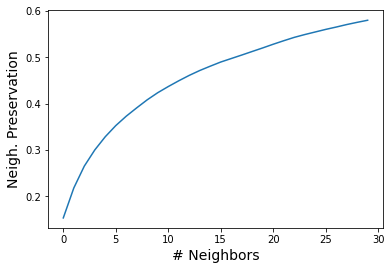

In [19]:

third_level = X[analysis_level2.landmark_orig_indexes,:]
third_embedding = analysis_level2.embedding

indices_3 = random.sample(range(0, len(third_embedding)), min(3000, len(third_embedding)))

third_embedding = third_embedding[indices_3]
third_level = third_level[indices_3]


noise = np.random.normal(0, .1, third_level.shape)
print("stress: ", stress(third_level, third_embedding))
print("demap: ", demap.DEMaP(third_level, third_embedding))
print("pearsonr: ", correlation(third_level, third_embedding))


ks = 30

npres = neighborhood_preservation(third_level, third_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-level2-np.png")
plt.show()

stress:  0.5894648642404733
demap:  0.6976875099935644
pearsonr:  0.32077007742854813
[0.18766667 0.20566667 0.22322222 0.22583333 0.23026667 0.23444444
 0.23633333 0.23808333 0.24037037 0.2411     0.24139394 0.24327778
 0.24551282 0.24838095 0.2502     0.25285417 0.25423529 0.25631481
 0.25882456 0.25948333 0.26180952 0.26381818 0.26608696 0.26843056
 0.27024    0.27164103 0.27353086 0.2757619  0.27727586 0.27874444]


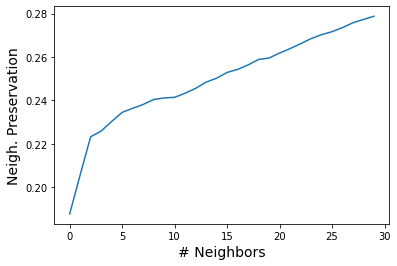

In [56]:

second_level = X[analysis_level1.landmark_orig_indexes,:]
second_embedding = analysis_level1.embedding


indices_2 = random.sample(range(0, len(second_embedding)), min(3000, len(second_embedding)))

second_embedding = second_embedding[indices_2]
second_level = second_level[indices_2]


print("stress: ", stress(second_level, second_embedding))
print("demap: ", demap.DEMaP(second_level, second_embedding))
print("pearsonr: ", correlation(second_level, second_embedding))


npres = neighborhood_preservation(second_level, second_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-level1-np.png")
plt.show()

In [28]:

first_level = X[analysis_level0.landmark_orig_indexes,:]
first_embedding = analysis_level0.embedding


indices_1 = random.sample(range(0, len(first_embedding)), min(3000, len(first_embedding)))

first_embedding = first_embedding[indices_1]
first_level = first_level[indices_1]

print("stress: ", stress(first_level, first_embedding))
print("demap: ", demap.DEMaP(first_level, first_embedding))
print("pearsonr: ", correlation(first_level, first_embedding))

npres = neighborhood_preservation(first_level, first_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-level0-np.png")
plt.show()

NameError: name 'analysis_level0' is not defined

stress:  0.3363926901315651


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (5000, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap:  0.6403481108782537
pearsonr:  0.6738607210850098
[0.101      0.1545     0.1994     0.23235    0.25768    0.28136667
 0.30214286 0.3209     0.33666667 0.35314    0.36707273 0.37891667
 0.38976923 0.39892857 0.40885333 0.41815    0.42651765 0.43366667
 0.44004211 0.44666    0.45344762 0.46002727 0.46668696 0.47259167
 0.477312   0.48256154 0.48737778 0.49237857 0.49697931 0.50150667]


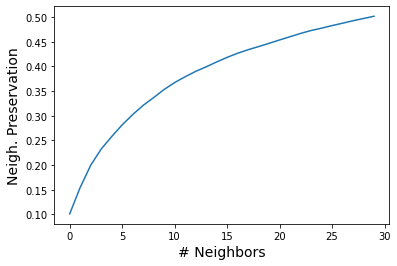

In [27]:
cluster_level = X[analysis_cluster1.landmark_orig_indexes,:]
cluster_embedding = analysis_cluster1.embedding

indices_cluster = random.sample(range(0, len(cluster_embedding)), min(5000, len(cluster_embedding)))

cluster_embedding = cluster_embedding[indices_cluster]
cluster_level = cluster_level[indices_cluster]

print("stress: ", stress(cluster_level, cluster_embedding))
print("demap: ", demap.DEMaP(cluster_level, cluster_embedding))
print("pearsonr: ", correlation(cluster_level, cluster_embedding))

ks = 30

npres = neighborhood_preservation(cluster_level, cluster_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-expand1-np.png")
plt.show()

stress:  0.37120857528630585


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (5000, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap:  0.6499320727647747
pearsonr:  0.5442842760199281
[0.1176     0.1683     0.19533333 0.21505    0.23516    0.2477
 0.25814286 0.26505    0.2718     0.278      0.28258182 0.28733333
 0.29201538 0.29624286 0.3004     0.3045625  0.30902353 0.3128
 0.31604211 0.31938    0.32270476 0.32583636 0.3282087  0.33034167
 0.332816   0.3358     0.33867407 0.34129286 0.34391034 0.34679333]


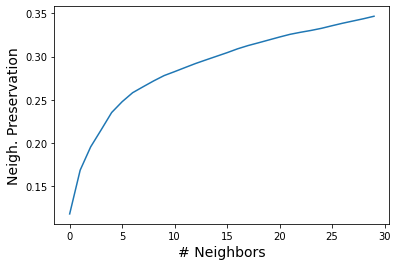

In [28]:
cluster_level = X[analysis_cluster.landmark_orig_indexes,:]
cluster_embedding = analysis_cluster.embedding

indices_cluster = random.sample(range(0, len(cluster_embedding)), min(5000, len(cluster_embedding)))

cluster_embedding = cluster_embedding[indices_cluster]
cluster_level = cluster_level[indices_cluster]

print("stress: ", stress(cluster_level, cluster_embedding))
print("demap: ", demap.DEMaP(cluster_level, cluster_embedding))
print("pearsonr: ", correlation(cluster_level, cluster_embedding))

ks = 30

npres = neighborhood_preservation(cluster_level, cluster_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-expand2-np.png")
plt.show()

In [47]:
cluster_level = X[analysis_cluster0.landmark_orig_indexes,:]
cluster_embedding = analysis_cluster0.embedding

indices_cluster = random.sample(range(0, len(cluster_embedding)), min(5000, len(cluster_embedding)))

cluster_embedding = cluster_embedding[indices_cluster]
cluster_level = cluster_level[indices_cluster]

print("stress: ", stress(cluster_level, cluster_embedding))
print("demap: ", demap.DEMaP(cluster_level, cluster_embedding))
print("pearsonr: ", correlation(cluster_level, cluster_embedding))

ks = 30

npres = neighborhood_preservation(cluster_level, cluster_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-expand3-np.png")
plt.show()

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by check_pairwise_arrays.